In [1]:
import keras
import tensorflow as tf

In [2]:
import os
from osgeo import gdal
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from glob import glob
from keras_unet.models import custom_unet, satellite_unet
from keras_unet.metrics import iou, iou_thresholded
from keras_unet.losses import jaccard_distance
from keras_unet.utils import plot_segm_history

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [3]:
# training data
base_dir = Path(r'e:\Google Drive\research\projects\utica')
mask_dir = base_dir.joinpath('mask')
train_image_dir = mask_dir.joinpath('u_train_reproject')
trees_mask_dir = mask_dir.joinpath('trees')
building_mask_dir = mask_dir.joinpath('building')
pavement_mask_dir = mask_dir.joinpath('pavement')

In [4]:
I, N, M = 60, 256, 256

In [5]:
os.listdir(mask_dir)

['building', 'desktop.ini', 'pavement', 'trees', 'u_train_reproject']

In [6]:
def make_path(img_dir, prefix, number):
    return os.path.join(img_dir, f"{prefix}_{number}.tif")

In [7]:
def img_number(fpath: str) -> int:
    return int(os.path.splitext(os.path.split(fpath)[1])[0].split('_')[-1])

In [8]:
def load_image(path: str) -> np.ndarray:
    ds = gdal.Open(path, gdal.GA_ReadOnly)
    return ds.GetRasterBand(1).ReadAsArray()[6:-7,6:-6]

In [9]:
def sorted_paths(img_dir: Path):
    return sorted(glob(img_dir.joinpath('*.tif').as_posix()), key=img_number)

In [10]:
def load_stack_safely(shape, dtype, img_dir, prefix):
    """
    Load a stack of images from disk into an ndarray.

    Performs the load potentially several times, to ensure that values
    stabilize. Google seems to be...tricky...
    """
    last_sum = 0
    while True:
        stack = np.zeros(shape=shape, dtype=dtype)
        for i in range(shape[0]):
            image_path = make_path(img_dir, prefix, i + 1)
            if not os.path.isfile(image_path):
                print("skipping", image_path)
                continue
            stack[i, :, :] = load_image(image_path)
        if stack.sum() == last_sum:
            break
        last_sum = stack.sum()
    return stack

In [11]:
train_images = load_stack_safely((I, N, M), np.float32, train_image_dir, "wgs_train")
tree_masks = load_stack_safely((I, N, M), np.int8, trees_mask_dir, "tree_mask")
building_masks = load_stack_safely((I, N, M), np.int8, building_mask_dir, "building_mask")
pavement_masks = load_stack_safely((I, N, M), np.int8, pavement_mask_dir, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_51.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_8.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_19.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_27.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_31.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_34.tif
skipping e:\Google Drive\research\projects\utica\mask\building\building_mask_5

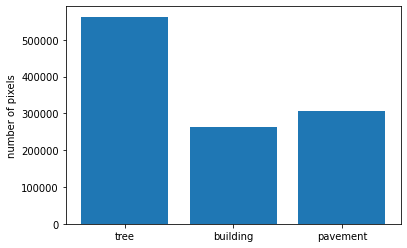

In [12]:
fig, ax = plt.subplots()
ax.bar(range(3), [tree_masks.sum(), building_masks.sum(), pavement_masks.sum()])
ax.set_xticks((0, 1, 2))
ax.set_xticklabels(('tree', 'building', 'pavement'))
plt.ylabel('number of pixels')
plt.show()

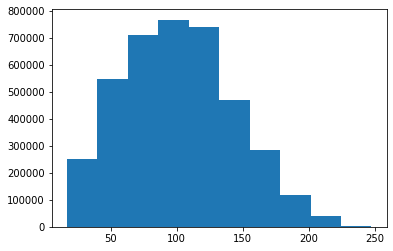

In [13]:
plt.hist(train_images.flatten())
plt.show()

In [14]:
model = satellite_unet(
    (N, M, 1),
    3,
    # dropout_type="spatial"
)

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    #optimizer=SGD(lr=0.01, momentum=0.99),
    loss='binary_crossentropy',
    #loss=jaccard_distance,
    metrics=[iou, iou_thresholded],
    
)

In [16]:
Y = np.zeros(shape=(I, N, M, 3), dtype=np.int8)
Y[:, :, :, 0] = tree_masks
Y[:, :, :, 1] = building_masks
Y[:, :, :, 2] = pavement_masks

In [17]:
Y.shape, tree_masks.shape

((60, 256, 256, 3), (60, 256, 256))

In [22]:
history = model.fit(
    train_images.reshape(I, N, M, 1),
    Y,
    epochs=100,
)

Epoch 1/100
2/2 [==============================] - 26s 12s/step - loss: 0.2235 - iou: 0.2066 - iou_thresholded: 0.2581
Epoch 2/100
2/2 [==============================] - 26s 12s/step - loss: 0.2124 - iou: 0.2181 - iou_thresholded: 0.2820
Epoch 3/100
2/2 [==============================] - 26s 12s/step - loss: 0.2055 - iou: 0.2244 - iou_thresholded: 0.2798
Epoch 4/100
2/2 [==============================] - 26s 12s/step - loss: 0.2004 - iou: 0.2537 - iou_thresholded: 0.3475
Epoch 5/100
2/2 [==============================] - 26s 12s/step - loss: 0.1932 - iou: 0.2597 - iou_thresholded: 0.3499
Epoch 6/100
2/2 [==============================] - 26s 12s/step - loss: 0.1853 - iou: 0.2810 - iou_thresholded: 0.3843
Epoch 7/100
2/2 [==============================] - 26s 12s/step - loss: 0.1782 - iou: 0.2991 - iou_thresholded: 0.4091
Epoch 8/100
2/2 [==============================] - 26s 12s/step - loss: 0.1672 - iou: 0.3248 - iou_thresholded: 0.4546
Epoch 9/100
2/2 [==============================]

2/2 [==============================] - 26s 12s/step - loss: 0.0320 - iou: 0.8137 - iou_thresholded: 0.8734
Epoch 70/100
2/2 [==============================] - 26s 12s/step - loss: 0.0324 - iou: 0.8125 - iou_thresholded: 0.8709
Epoch 71/100
2/2 [==============================] - 26s 12s/step - loss: 0.0332 - iou: 0.8126 - iou_thresholded: 0.8685
Epoch 72/100
2/2 [==============================] - 26s 12s/step - loss: 0.0329 - iou: 0.8154 - iou_thresholded: 0.8690
Epoch 73/100
2/2 [==============================] - 26s 12s/step - loss: 0.0310 - iou: 0.8227 - iou_thresholded: 0.8774
Epoch 74/100
2/2 [==============================] - 26s 12s/step - loss: 0.0277 - iou: 0.8346 - iou_thresholded: 0.8904
Epoch 75/100
2/2 [==============================] - 26s 12s/step - loss: 0.0297 - iou: 0.8286 - iou_thresholded: 0.8809
Epoch 76/100
2/2 [==============================] - 26s 12s/step - loss: 0.0342 - iou: 0.8119 - iou_thresholded: 0.8629
Epoch 77/100
2/2 [==============================] - 2

In [23]:
Y_pred = model.predict(train_images.reshape(I, N, M, 1))

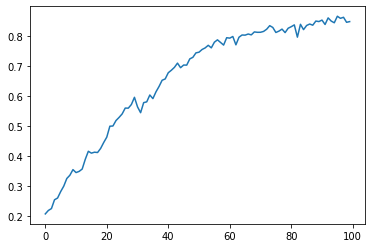

In [27]:
plt.plot(history.history['iou'])

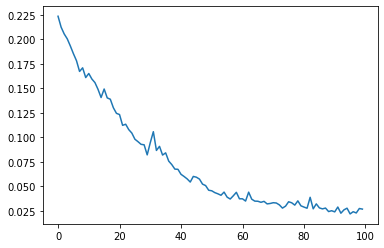

In [28]:
plt.plot(history.history['loss'])

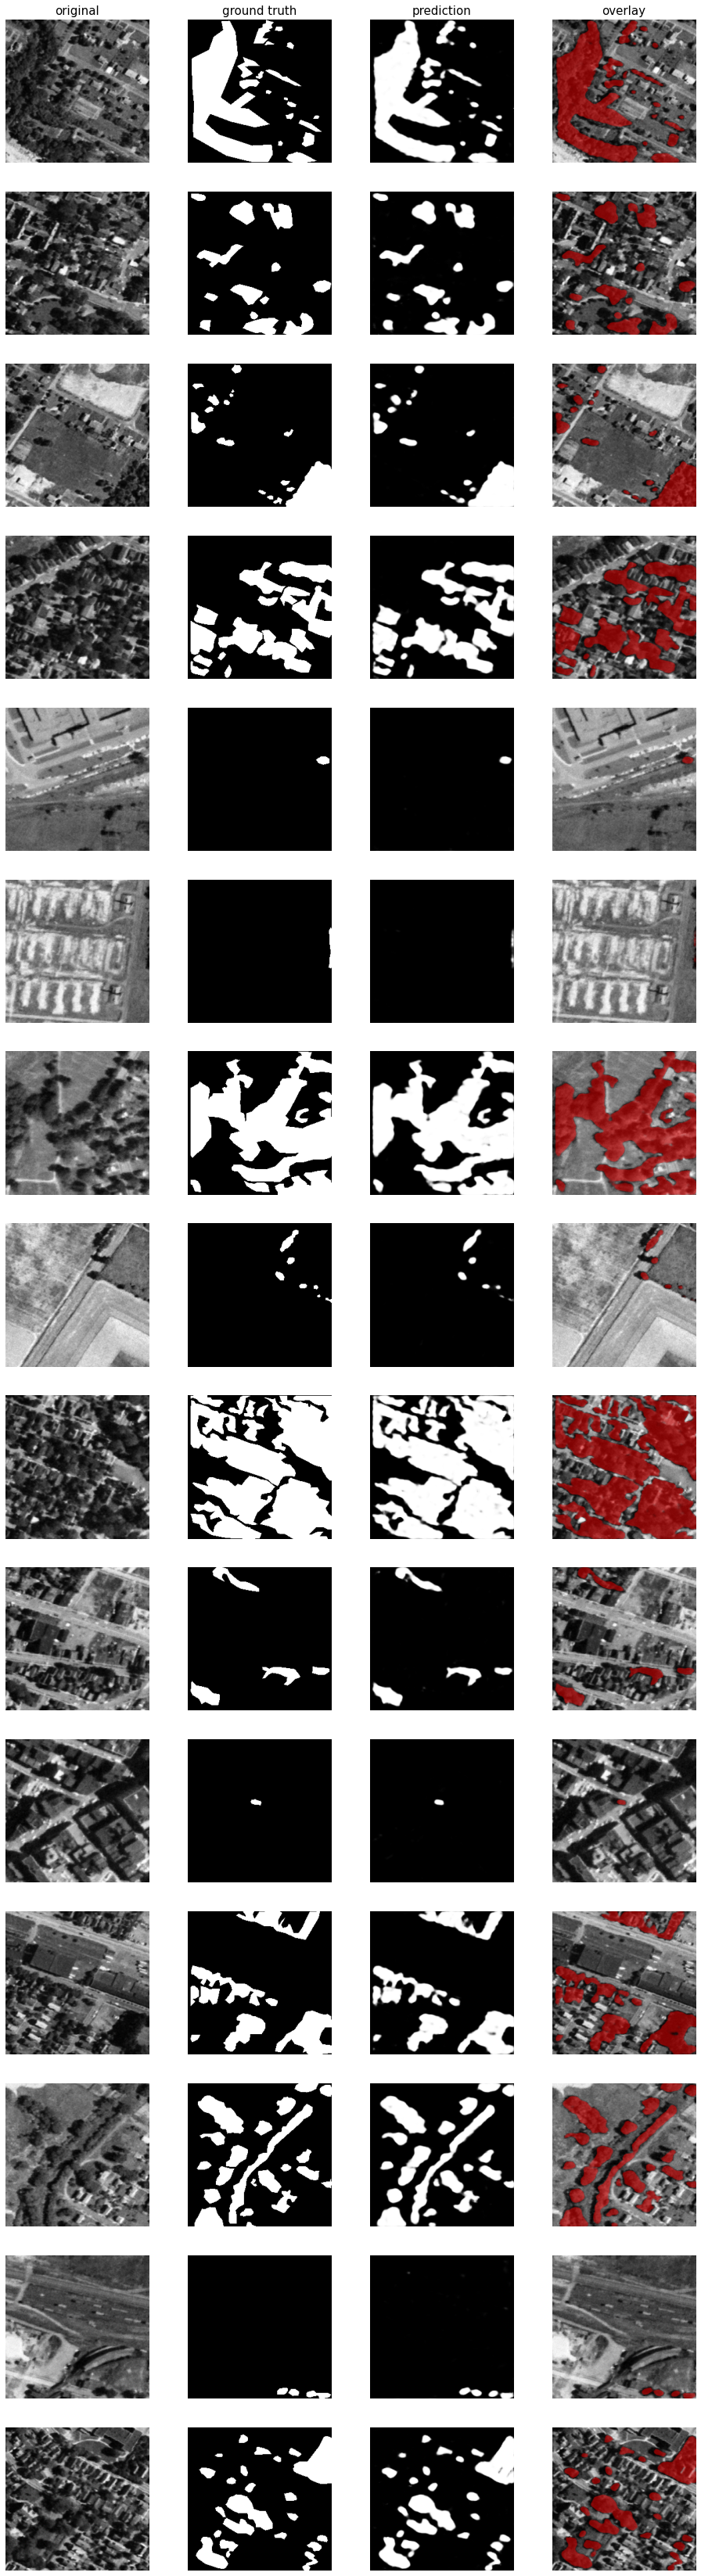

In [24]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 0], 
    pred_imgs=Y_pred[:, :, :, 0], 
    nm_img_to_plot=15
  )

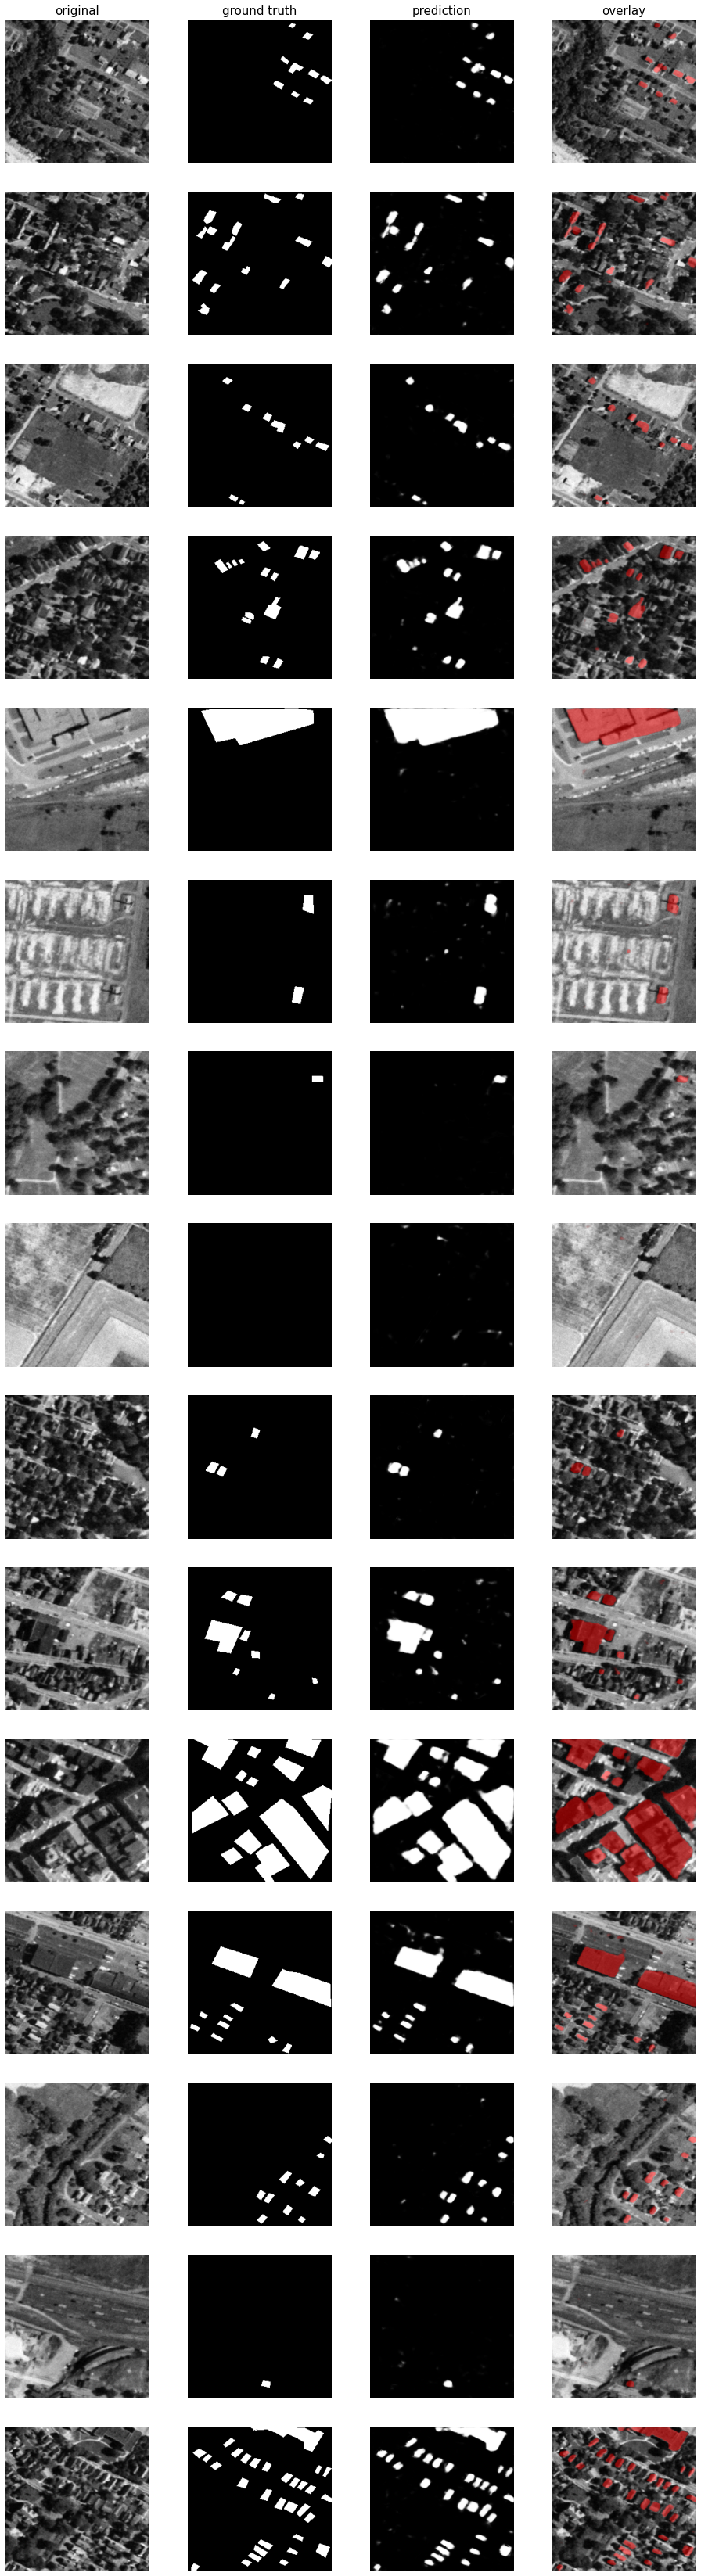

In [25]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 1], 
    pred_imgs=Y_pred[:, :, :, 1], 
    nm_img_to_plot=15
  )

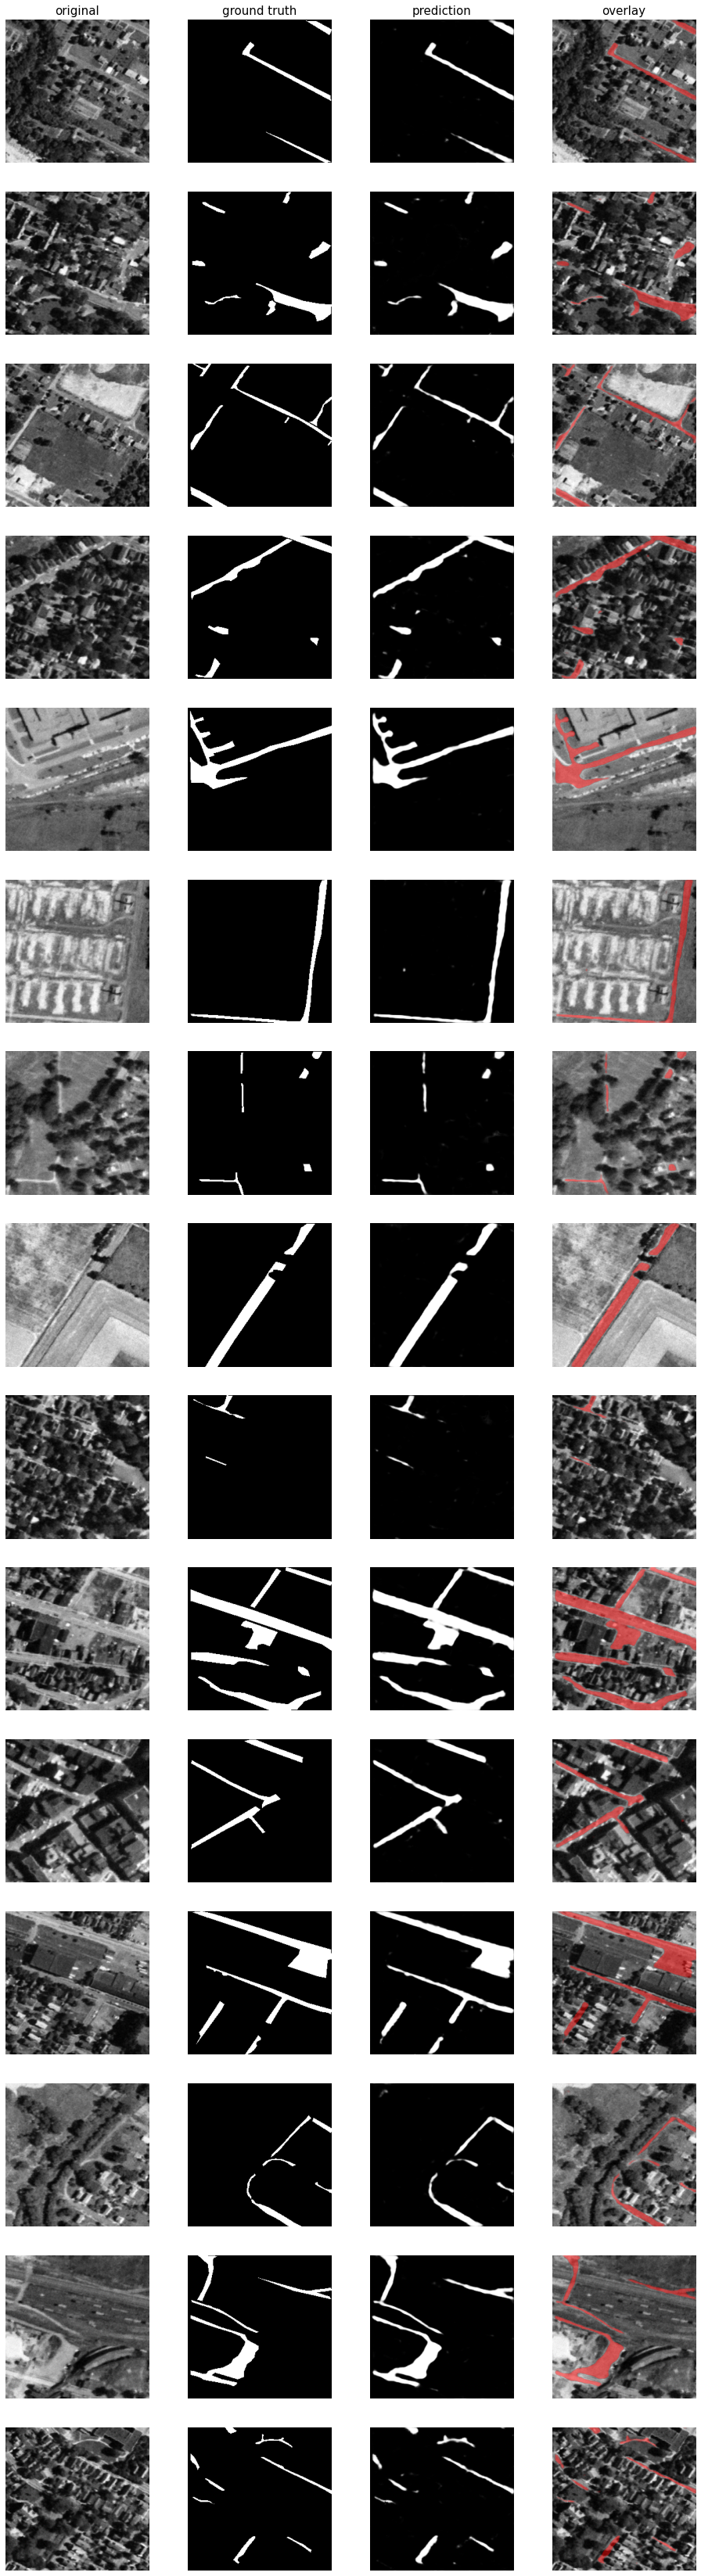

In [26]:
from keras_unet.utils import plot_imgs

plot_imgs(
    org_imgs=train_images.reshape(I, N, M, 1), 
    mask_imgs=Y[:, :, :, 2], 
    pred_imgs=Y_pred[:, :, :, 2], 
    nm_img_to_plot=15
  )

In [37]:
# validation data
base_dirV = Path(r'e:\Google Drive\research\projects\utica')
mask_dirV = base_dir.joinpath('mask_50s_valid')
train_image_dirV = mask_dirV.joinpath('u_valid_reproject')
trees_mask_dirV = mask_dirV.joinpath('trees')
building_mask_dirV = mask_dirV.joinpath('building')
pavement_mask_dirV = mask_dirV.joinpath('pavement')

In [38]:
K, N, M = 20, 256, 256

In [39]:
valid_images = load_stack_safely((K, N, M), np.float32, train_image_dirV, "wgs_valid")
tree_valid = load_stack_safely((K, N, M), np.int8, trees_mask_dirV, "tree_mask")
building_valid = load_stack_safely((K, N, M), np.int8, building_mask_dirV, "building_mask")
pavement_valid = load_stack_safely((K, N, M), np.int8, pavement_mask_dirV, "pavement_mask")

skipping e:\Google Drive\research\projects\utica\mask_50s_valid\building\building_mask_4.tif
skipping e:\Google Drive\research\projects\utica\mask_50s_valid\building\building_mask_4.tif


In [41]:
Yvalid = np.zeros(shape=(K, N, M, 3), dtype=np.int8)
Yvalid[:, :, :, 0] = tree_valid
Yvalid[:, :, :, 1] = building_valid
Yvalid[:, :, :, 2] = pavement_valid

In [42]:
Y_valid = model.predict(valid_images.reshape(K, N, M, 1))

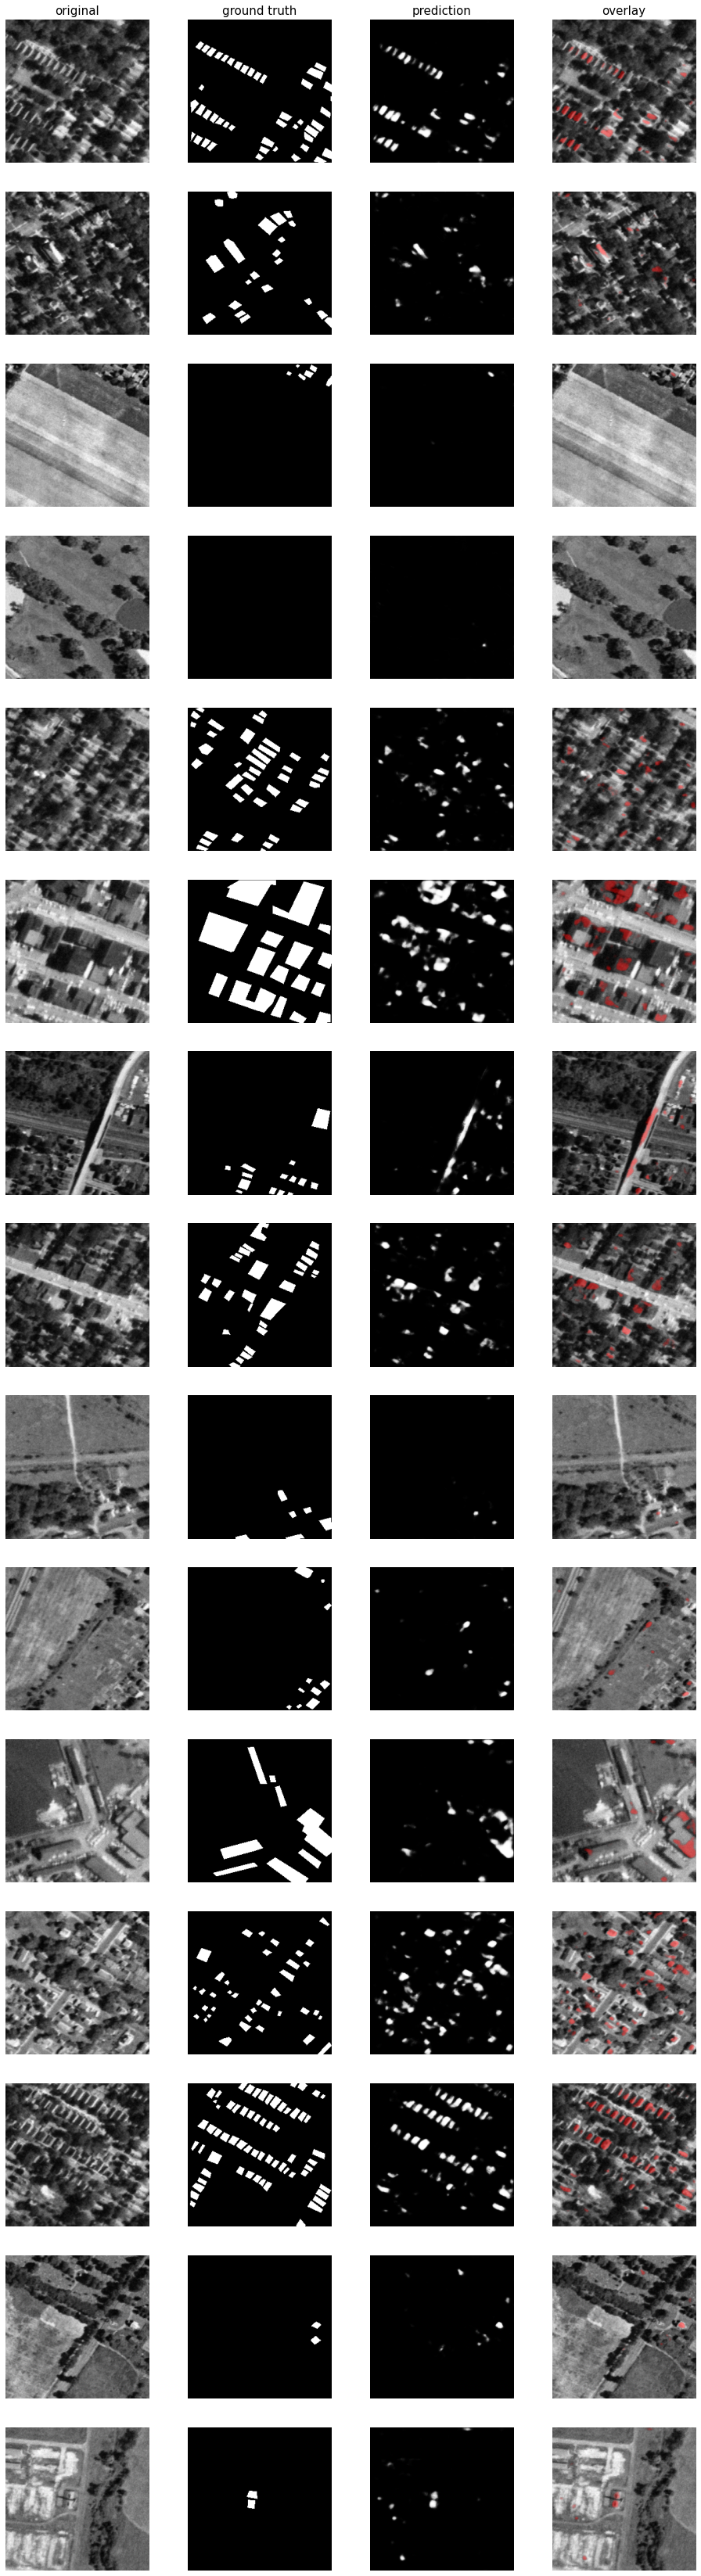

In [43]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 1], 
    pred_imgs=Y_valid[:, :, :, 1], 
    nm_img_to_plot=15
  )

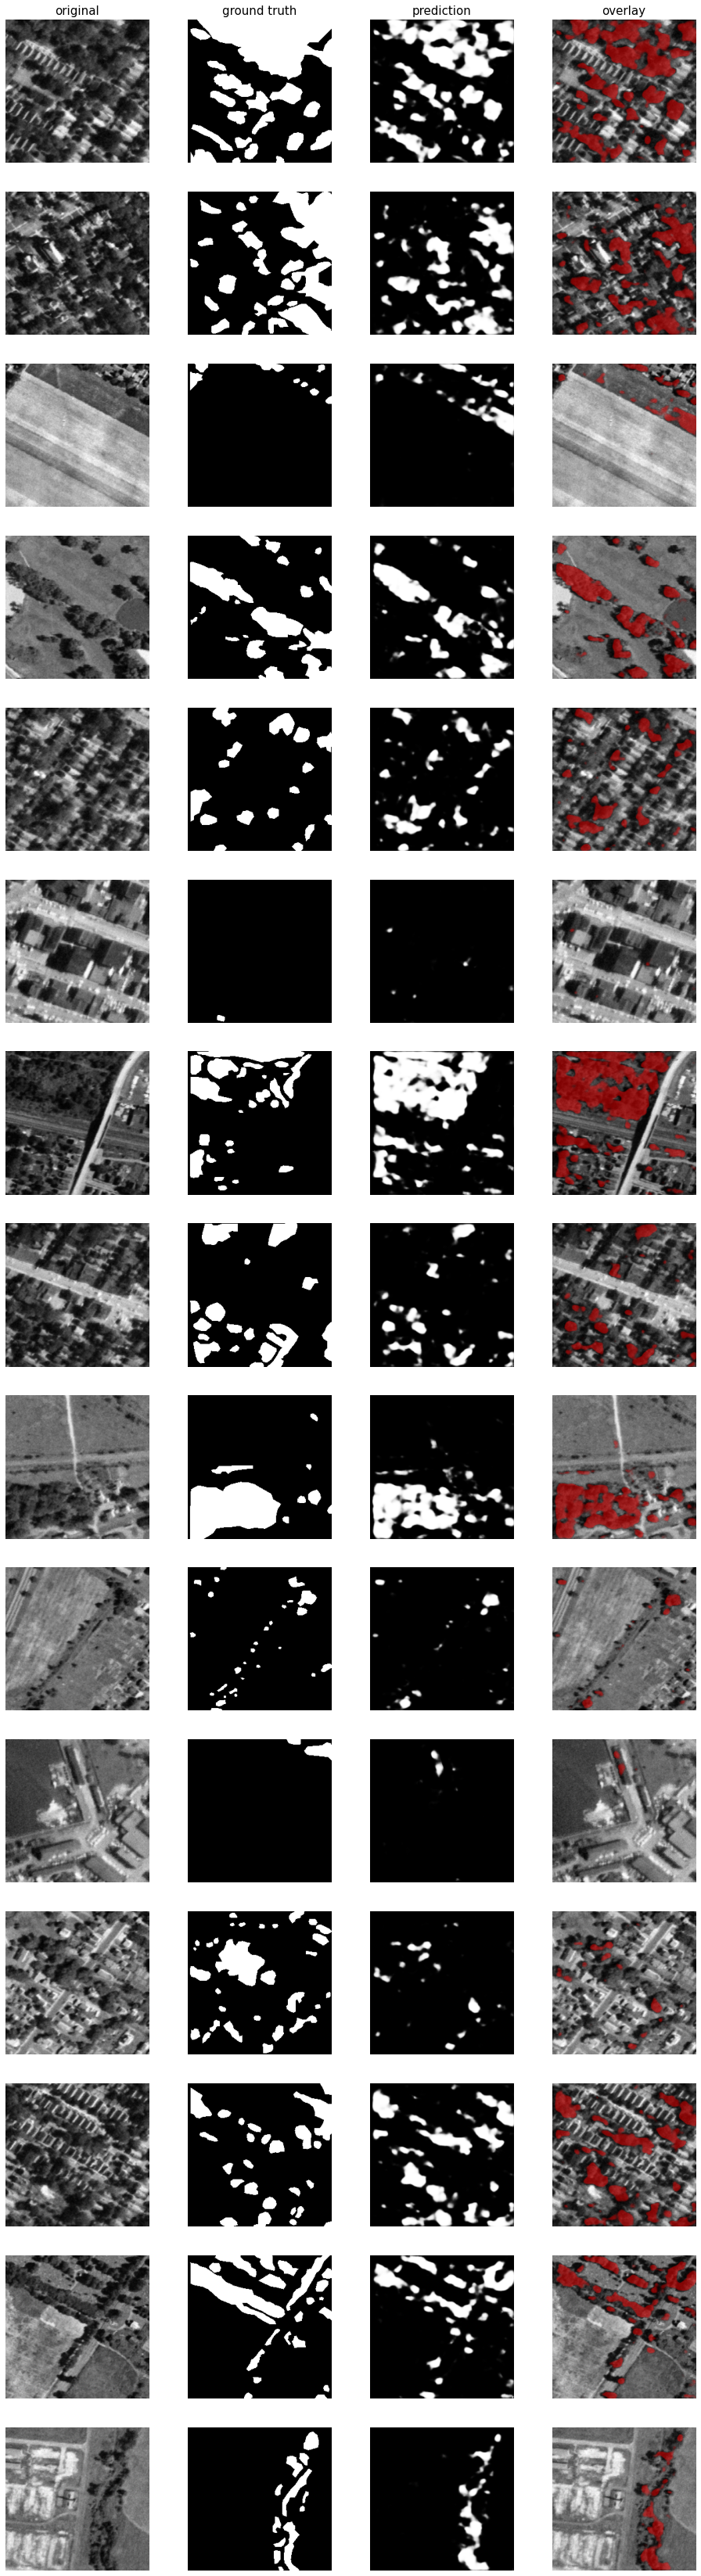

In [45]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 0], 
    pred_imgs=Y_valid[:, :, :, 0], 
    nm_img_to_plot=15
  )

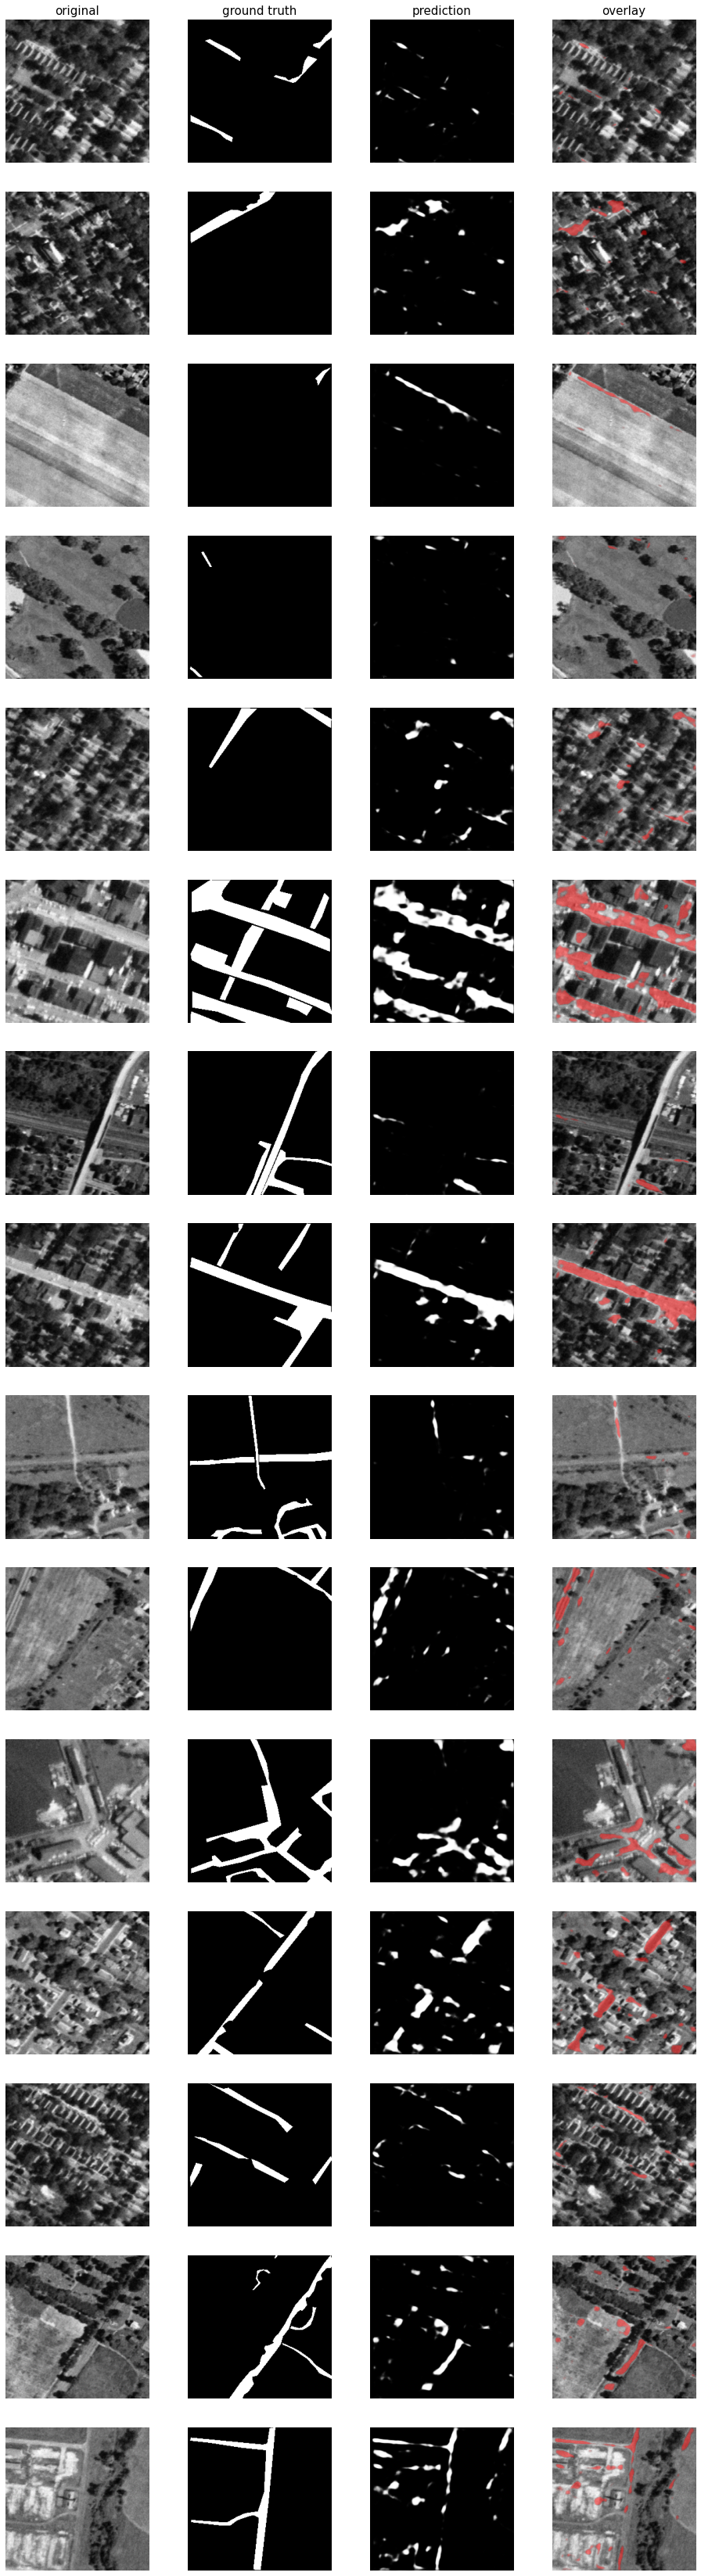

In [46]:
plot_imgs(
    org_imgs=valid_images.reshape(K, N, M, 1), 
    mask_imgs=Yvalid[:, :, :, 2], 
    pred_imgs=Y_valid[:, :, :, 2], 
    nm_img_to_plot=15
  )